## Setting Up Google Colab for Geospatial Analysis

In [5]:
!pip install rasterio
!pip install geopandas
!pip install folium
!pip install matplotlib
!pip install numpy
!pip install plotly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.7/21.7 MB 77.2 MB/s eta 0:00:00


In [7]:
import rasterio
from rasterio.plot import show
import geopandas as gpd
import folium
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import plotly.graph_objects as go

## Accessing Data

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Loading and Exploring the Raster Data

In [9]:
# Provide the correct path to your TIFF file
tiff_file = '/content/drive/MyDrive/Earth Observation Competition - 2024/Sentinel2_AOI-0000000000-0000000000.tif'

dataset = rasterio.open(tiff_file)

In [10]:
print("Coordinate Reference System (CRS):", dataset.crs)
print("Image Bounds:", dataset.bounds)
print("Number of Bands:", dataset.count)
print("Image Width:", dataset.width)
print("Image Height:", dataset.height)

Coordinate Reference System (CRS): EPSG:4326
Image Bounds: BoundingBox(left=48.251658013553914, bottom=39.75323609966959, right=48.73459231029657, top=40.08534326020858)
Number of Bands: 19
Image Width: 5376
Image Height: 3697


## Visualizing the Raster Data

In [11]:
# Read all bands
bands = dataset.read()

# Check the shape of the data
print(bands.shape)  # (bands, rows, columns)

(19, 3697, 5376)


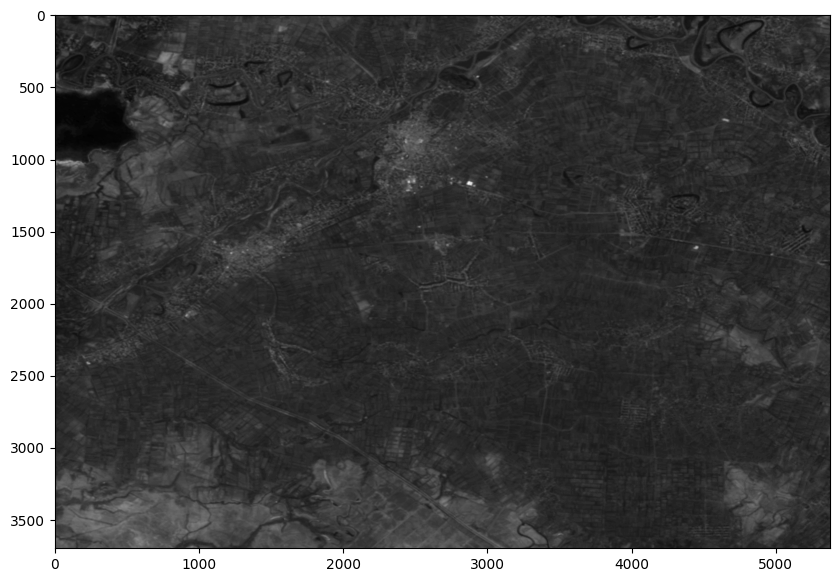

In [12]:
# Display Band 1
plt.figure(figsize=(10, 10))
ax = show(dataset.read(1), cmap='gray')

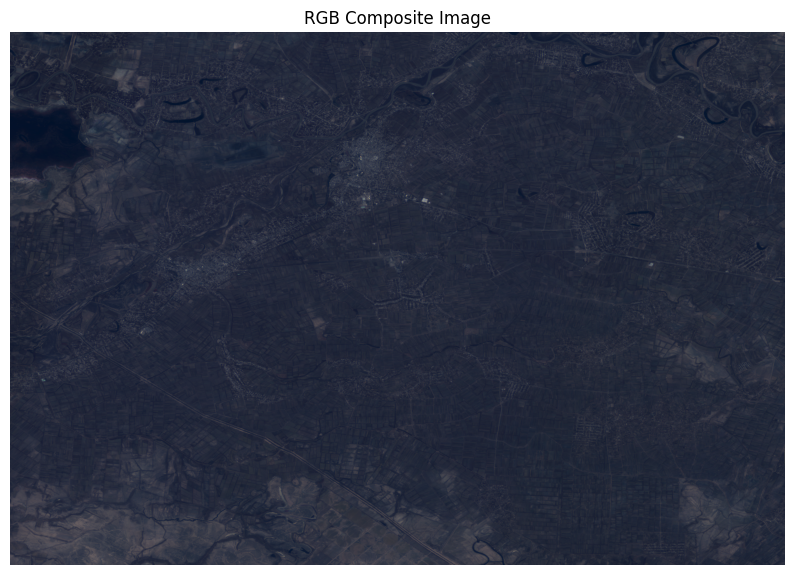

In [13]:
# Adjust indices based on your data (Python indexing starts at 0)
blue = bands[0]
green = bands[1]
red = bands[2]

# Stack bands to create an RGB image
rgb = np.dstack((red, green, blue))

# Normalize the data for display
def normalize(array):
    array_min, array_max = array.min(), array.max()
    return ((array - array_min) / (array_max - array_min))

rgb_norm = normalize(rgb)

# Display the RGB image
plt.figure(figsize=(10, 10))
plt.imshow(rgb_norm)
plt.title('RGB Composite Image')
plt.axis('off')
plt.show()

## Interactive Visualization with Folium

In [14]:
from rasterio.enums import Resampling

# Define the scale factor
scale_factor = 0.1  # Adjust to reduce the image size

# Calculate new dimensions
new_height = int(dataset.height * scale_factor)
new_width = int(dataset.width * scale_factor)

# Resample the data
data_resampled = dataset.read(
    out_shape=(
        dataset.count,
        new_height,
        new_width
    ),
    resampling=Resampling.bilinear
)

# Update transform
transform = dataset.transform * dataset.transform.scale(
    (dataset.width / data_resampled.shape[-1]),
    (dataset.height / data_resampled.shape[-2])
)

In [15]:
# Prepare RGB image
red_resampled = data_resampled[2]
green_resampled = data_resampled[1]
blue_resampled = data_resampled[0]

rgb_resampled = np.dstack((red_resampled, green_resampled, blue_resampled))
rgb_resampled_norm = normalize(rgb_resampled)

# Convert to 8-bit integers
rgb_resampled_norm = (rgb_resampled_norm * 255).astype(np.uint8)


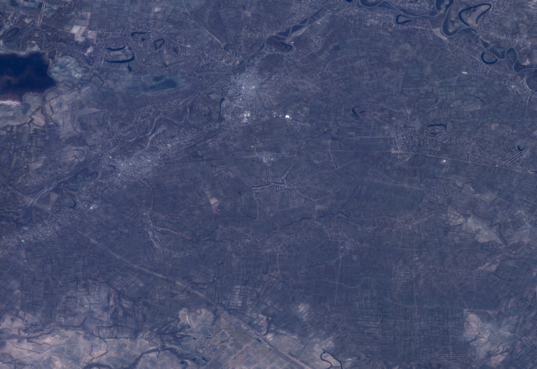

In [16]:
# Calculate the center of the image
center_lat = (dataset.bounds.top + dataset.bounds.bottom) / 2
center_lon = (dataset.bounds.left + dataset.bounds.right) / 2

# Create a Folium map
m = folium.Map(location=[center_lat, center_lon], zoom_start=12)

# Add the image overlay
folium.raster_layers.ImageOverlay(
    image=rgb_resampled_norm,
    bounds=[[dataset.bounds.bottom, dataset.bounds.left], [dataset.bounds.top, dataset.bounds.right]],
    opacity=0.7,
    interactive=True,
    cross_origin=False,
    zindex=1,
).add_to(m)

# Display the map
m

## Calculating Vegetation Indices

In [17]:
# Assuming 'bands' is obtained as follows
bands = dataset.read()

# Correct band indices (zero-based indexing)
red = bands[3].astype('float32')  # Band 4
nir = bands[7].astype('float32')  # Band 8

# Apply scaling factor
scale_factor = 1 / 10000
red_reflectance = red * scale_factor
nir_reflectance = nir * scale_factor

# Calculate NDVI
ndvi = (nir_reflectance - red_reflectance) / (nir_reflectance + red_reflectance)

# Handle NaN values
ndvi = np.nan_to_num(ndvi, nan=0.0, posinf=0.0, neginf=0.0)

In [18]:
# Read SCL band (Band 15)
scl_band = bands[14]

# Define cloud classes
cloud_classes = [3, 8, 9, 10, 11]

# Create a mask for clear pixels
clear_mask = ~np.isin(scl_band, cloud_classes)

# Apply mask to NDVI
ndvi_masked = np.where(clear_mask, ndvi, np.nan)

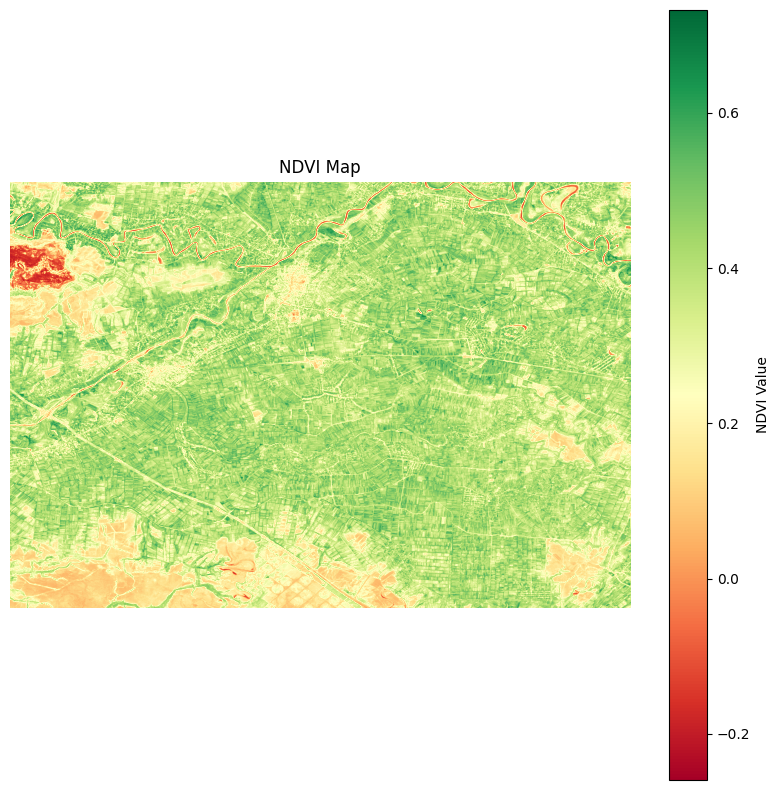

In [19]:
plt.figure(figsize=(10, 10))
plt.imshow(ndvi_masked, cmap='RdYlGn')
plt.colorbar(label='NDVI Value')
plt.title('NDVI Map')
plt.axis('off')
plt.show()

## Integrating with Machine Learning

In [20]:
# Flatten the arrays
red_flat = red.flatten()
nir_flat = nir.flatten()

# Create a DataFrame
import pandas as pd

df = pd.DataFrame({
    'Red': red_flat,
    'NIR': nir_flat,
    'NDVI': ndvi.flatten()
})

# Remove NaN values
df = df.dropna()

In [21]:
df.describe()

,Red,NIR,NDVI
count,1.987507e+07,1.987507e+07,1.987507e+07
mean,1.183789e+03,2.547967e+03,3.597877e-01
std,2.432662e+02,4.086861e+02,1.275235e-01
min,4.722286e+02,3.302857e+02,-2.595624e-01
25%,1.035545e+03,2.354143e+03,2.905095e-01
50%,1.136929e+03,2.593750e+03,3.823710e-01
75%,1.294467e+03,2.799636e+03,4.496478e-01
max,4.418897e+03,4.380950e+03,7.327156e-01


In [23]:
ndvi_flat = ndvi_masked.flatten()
ndvi_flat = ndvi_flat[~np.isnan(ndvi_flat)]
df = pd.DataFrame({'NDVI': ndvi_flat})
print(df.describe())

               NDVI
count  1.987507e+07
mean   3.597877e-01
std    1.275235e-01
min   -2.595624e-01
25%    2.905095e-01
50%    3.823710e-01
75%    4.496478e-01
max    7.327156e-01


In [22]:
df.to_csv("ndvi_results.csv")

KeyboardInterrupt: 

## Azercosmos Data

In [ ]:
import rasterio

# Open the dataset
dataset = rasterio.open('/content/drive/MyDrive/Earth Observation Competition - 2024/IMG_SP~1.TIF')

# Print the CRS
print("Coordinate Reference System (CRS):", dataset.crs)